# Transfer Learning con Redes Convolucionales Pre-entrenadas

Antes de proceder, intenta solicitar una GPU en Colab para poder entrenar el modelo de manera efectiva. Ve a *Entorno de ejecución -> Cambiar tipo de entorno de ejecución*, y elige GPU.

In [1]:
%tensorflow_version 1.x
import keras
keras.__version__

TensorFlow 1.x selected.


Using TensorFlow backend.


'2.3.1'

In [2]:
# Evalúa la celda para descargar algunos ficheros auxiliares
import os
work_dir = "/content/TL-tutorial/"
if os.getcwd() != work_dir:
    !git clone https://github.com/miguelamda/TL-tutorial.git
os.chdir(work_dir)

fatal: destination path 'TL-tutorial' already exists and is not an empty directory.


Una aproximación muy común y efectiva cuando se trabaja con Deep Learning sobre datasets pequeños es reutilizar redes preentrenadas. Una red preentrenada es simplemente una red grabada que ha sido entrenada sobre un dataset grande, algo muy común cuando se trabaja con problemas de clasificación de imágenes. 

Si este dataset original es suficientemente grande y suficientemente general, entonces la jerarquía de características espaciales que ha aprenido la red preentrenada puede servir como modelo genérico de nuestro mundo visual y, por tanto, sus características pueden ser útiles para muchos problemas de visión diferentes, incluso aunque estos nuevos problemas involucren clases completamente distintas a las de la tarea original. 

Por ejemplo, uno puede entrenar una red sobre [ImageNet](http://www.image-net.org) (donde las clases son principalmente de animales y objetos de uso diario) y reutilizarlo para algo tan distinto como identificar muebles. Esta portabilidad de características aprendidas entre diferentes problemas (que se suele denominar **Transfer Learning**, o **Transferencia de Aprendizaje**) es una ventaja clave de Deep Learning en comparación con muchas otras aproximaciones clásicas de ML, y hace que DL pueda ser apropiado para atacar problemas con datasets pequeños (en contra de lo que se cree generalmente).

En el ejemplo que vamos a ver a continuación consideraremos una CNN entrenada sobre el dataset ImageNet (usando 1.4 millones de imágenes etiquetadas en 1,000 clases diferentes), que contiene clases de muchos animales, en particular diferentes tipos de cubertería, así que podemos esperar que funcione bien sobre el problema de clasificación que veremos a continuación.

Vamos a usar la arquitectura [VGG16](http://www.robots.ox.ac.uk/~vgg/research/very_deep/), desarrollada por Karen Simonyan y Andrew Zisserman en 2014, y que ha sido muy usada desde entonces para este tipo de problemas. Aunque es un modelo un poco viejo, y ya superado por muchos otros modelos similares, lo usaremos porque hace uso de arquitecturas parecidas a las de ejemplos anteriores, permitiéndonos concentrarnos en las novedades que introduciremos.

![](https://github.com/miguelamda/DL/blob/master/5.%20Redes%20Convolucionales/imgs/vgg16.png?raw=1)

En los que sigue, vamos a hacer una aproximación para reutilizar modelos pre-entrenados: **Extracción de Características**. Hay otras variantes, como el **Ajuste Fino**, pero esto no podremos cubrirlo en esta sesión.

## 1 Clasificación de imágenes con VGG16 <a class="anchor" id="incepclasif"></a>

Antes de continuar, vamos a análizar qué tal se comporta la red VGG16, pre-entrenada sobre el dataset [ImageNet](http://www.image-net.org/). Primero tendremos que obtener dicho modelo, lo cual es sencillo con Keras.

A continuación nos descargaremos el modelo VGG16 ya disponible en Keras.

In [3]:
from keras.applications.vgg16 import VGG16, decode_predictions

modeloVGG16 = VGG16()          

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Vamos a definir una función auxiliar que nos ayudará en la tarea de clasificar imágenes: muestra la imagen, la clasifica usando el modelo cargado, e imprime las puntuaciones (scores) de clasificación. Por tanto, necesitamos dicha función de ayuda para cargar y redimensionar una imagen para que pueda ser introducida en el modelo VGG16, así como para hacer la predicción real y mostrar el resultado.

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import PIL
import numpy as np
import os

# Esta función recibe la ruta a una imagen, y devuelve la imagen en sí con
# la predicción que devuelva el modelo VGG16
def predict(image_path):
    # Carga y redimensiona la imagen usando PIL.
    img = PIL.Image.open(image_path)
    #input_shape = model.layers[0].output_shape[1:3]
    img_resized = img.resize((224,224), PIL.Image.LANCZOS)

    # Dibuja la imagen.
    plt.imshow(img_resized)
    plt.axis('off')
    plt.show()

    # Convierte la imagen PIL a un numpy-array con la forma (shape) apropiada.
    img_array = np.expand_dims(np.array(img_resized), axis=0)

    # Usa el modelo VGG16 para hacer la predicción.
    # Esto devuelve un array con 1000 números, correspondientes a
    # las clases del dataset ImageNet.
    pred = modeloVGG16.predict(img_array)
    
    # Decodifica la salida del modelo VGG16.
    pred_decoded = decode_predictions(pred)[0]

    # Imprime las predicciónes.
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))

Usemos el modelo VGG16 en la foto del loro que debería ser clasificado como guacamayo (macaw, una especie de loro).

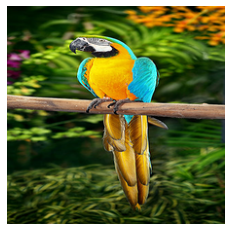


23.42% : knot
12.41% : macaw
11.89% : coral_reef
10.28% : snorkel
 8.28% : gar


In [5]:
predict(image_path='images/parrot.jpg')

El modelo VGG16 funciona con imágenes de entrada de 224 x 224 píxeles de tamaño. La imagen de arriba de un loro tiene en realidad 320 píxeles de ancho y 785 píxeles de alto, por lo que es redimensionada automáticamente para el modelo VGG16. Podemos ver que ha sido apretado para que sea cuadrado, y la resolución se ha reducido para que la imagen sea más pixelada y granulada.

En este caso, aunque la imagen muestra claramente un loro, al distorsionarse tanto el modelo VGG16 se equivoca y cree que se trata de un nudo con un 23%, y un macaw con un solo 12,4%.

### Imagen Recortada, arriba

Esta imagen del loro se ha recortado manualmente a una dimensión cercana a 224 x 224 píxeles y luego se ha introducido en el modelo. Ahora sí, VGG16 está seguro (puntuación de alrededor del 79%) de que muestra un loro (guacamayo).

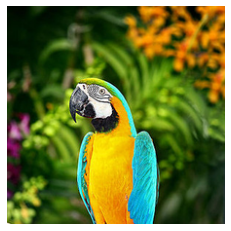

79.02% : macaw
 6.61% : bubble
 3.64% : vine_snake
 1.90% : pinwheel
 1.22% : knot


In [6]:
predict(image_path='images/parrot_cropped1.jpg')

### Imagen Recortada, en el centro

Esto es otro recorte de la imagen del loro, esta vez mostrando su cuerpo sin cabeza ni cola. El modelo VGG16 tiene aún más confianza (puntuación de alrededor del 99,8%) de que muestra un loro guacamayo. El modelo debe haber aprendido a detectarlo por su cuerpo, y no por la cabeza.

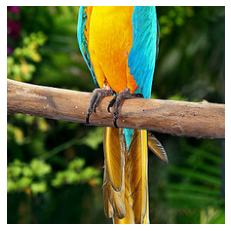

99.88% : macaw
 0.10% : lorikeet
 0.01% : bee_eater
 0.01% : toucan
 0.01% : indigo_bunting


In [7]:
predict(image_path='images/parrot_cropped2.jpg')

### Imagen Recortada, abajo

Esta imagen ha sido recortada por lo que sólo muestra la cola del loro. Ahora el modelo VGG16 está algo confundido, piensa que podría tratarse de un macaw (51,2%), también podría mostrar un jacamar (puntuación de alrededor del 15,7%) que es otro ave exótica, o quizás la imagen muestra un carrao (limpkin, otra ave, con puntuación de alrededor del 4%). Esto último es una puntuación muy baja y debe interpretarse como un ruido poco fiable. 

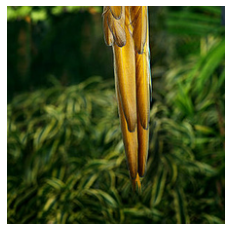

51.24% : macaw
15.74% : jacamar
 4.08% : limpkin
 3.36% : black_stork
 2.85% : bee_eater


In [8]:
predict(image_path='images/parrot_cropped3.jpg')

### Imagen Rellenada

La mejor manera de introducir imágenes es rellenar la imagen para que sea cuadrada (en blanco a los lados) y luego redimensionarla a 240 x 240 píxeles, como este ejemplo del loro que está clasificado con una puntuación de alrededor del 29.86%, pero existe mucho ruido. El modelo está algo confuso.

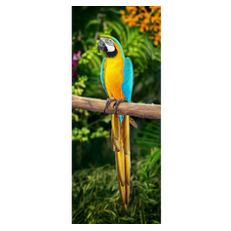

29.84% : macaw
11.79% : bubble
11.09% : bee_eater
 4.76% : web_site
 4.22% : hook


In [9]:
predict(image_path='images/parrot_padded.jpg')

### Willy Wonka 

#### Gene Wilder

Esta imagen muestra al actor Gene Wilder interpretando a Willy Wonka en la versión de la película de 1971. El modelo VGG16 está muy seguro de que la imagen muestra una pajarita (bow tie, puntuación de alrededor del 92,4%), lo que es cierto, pero un humano probablemente diría que esta imagen muestra a una persona.

La razón podría ser que el modelo fue entrenado en imágenes de personas con pajaritas que fueron clasificadas como pajaritas en lugar de personas. Así que tal vez el problema es que el nombre de la clase debería ser "persona con pajarita" en lugar de sólo "pajarita".

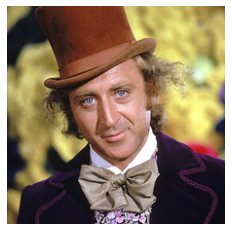

92.40% : bow_tie
 2.59% : military_uniform
 1.31% : bonnet
 1.28% : cowboy_hat
 0.46% : pinwheel


In [10]:
predict(image_path='images/willy_wonka_old.jpg')

#### Johnny Depp

Esta imagen muestra al actor Johnny Depp interpretando a Willy Wonka en la versión de 2005 de la película. El modelo piensa que esta imagen muestra "máscara" (mask, puntuación aproximada del 42%) o "máscara de esquí" (ski_mask, puntuación aproximada del 30%). El modelo VGG16 ha sido entrenado para reconocer máscaras quizás enfocado en los ojos. Si hubiéramos empleado la red Inception, habríamos obtenido una alta puntuación en "gafas de sol".

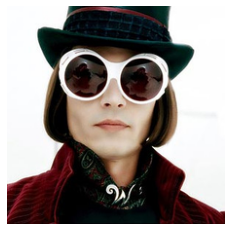

42.44% : mask
30.38% : ski_mask
18.54% : gasmask
 1.24% : loupe
 1.09% : binoculars


In [11]:
predict(image_path='images/willy_wonka_new.jpg')

## 2. El Dataset Knifey-Spoony

Para demostrar como usar transfer learning y fine tuning, usaremos un nuevo conjunto de datos llamado [Knifey-Spoony](https://github.com/Hvass-Labs/knifey-spoony) que contiene miles de imágenes de cuchillos, cucharas y tenedores sobre unos cuantos fondos diferentes. El conjunto de entrenamiento (training) contiene 4.170 imágenes y el de pruebas (test) 530 imágenes. Las clases se denominan knifey, spoony y forky como referencia a [Los Simpsons](https://www.youtube.com/watch?v=mcE0aAhbVFc).

![knifey-spoony](https://github.com/Hvass-Labs/knifey-spoony/raw/master/images/simpsons.jpg)

La descarga y la extracción del dataset ya viene automatizado en el fichero [`knifey.py`](./knifey.py), que se debe tener descargado.

In [12]:
# Carga el dataset empleando el fichero knifey.py
import knifey

# Descarga el dataset, si no lo ha hecho ya, lo que ocupa 22MB
knifey.maybe_download_and_extract()

# Mostremos el contenido en carpetas
!echo "El contenido de la carpeta es: "
!ls data/knifey-spoony
!echo "Por ejemplo, la carpeta forky contiene: "
!ls data/knifey-spoony/forky | head

Data has apparently already been downloaded and unpacked.
El contenido de la carpeta es: 
forky	knifey-spoony.pkl     README.md  test
knifey	knifey-spoony.tar.gz  spoony	 train
Por ejemplo, la carpeta forky contiene: 
forky-01-0001.jpg
forky-01-0002.jpg
forky-01-0003.jpg
forky-01-0004.jpg
forky-01-0005.jpg
forky-01-0006.jpg
forky-01-0007.jpg
forky-01-0008.jpg
forky-01-0009.jpg
forky-01-0010.jpg


Este dataset tiene una estructura de directorios distinta que la requerida por Keras, por tanto copiaremos los ficheros en directorios separados para los conjuntos de pruebas (training) y pruebas (test). Esto ya está automatizado en el fichero `knifey.py`, para que vayamos al grano.

In [13]:
knifey.copy_files()
train_dir = knifey.train_dir
test_dir = knifey.test_dir

Creating dataset from the files in: data/knifey-spoony/
- Data loaded from cache-file: data/knifey-spoony/knifey-spoony.pkl
- Copied training-set to: data/knifey-spoony/train/
- Copied test-set to: data/knifey-spoony/test/


In [14]:
!echo "El contenido de la carpeta es: "
!ls data/knifey-spoony
!echo "Por ejemplo, la carpeta train contiene: "
!ls data/knifey-spoony/train

El contenido de la carpeta es: 
forky	knifey-spoony.pkl     README.md  test
knifey	knifey-spoony.tar.gz  spoony	 train
Por ejemplo, la carpeta train contiene: 
forky  knifey  spoony


Ahora mostraremos algunos ejemplos de imágenes, y su predicción con VGG16, para que tomemos una idea.

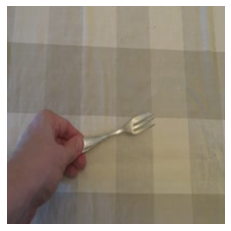

45.08% : shower_curtain
21.84% : mosquito_net
11.55% : handkerchief
 2.02% : window_shade
 0.91% : Windsor_tie


In [15]:
predict(image_path='data/knifey-spoony/forky/forky-01-0002.jpg')

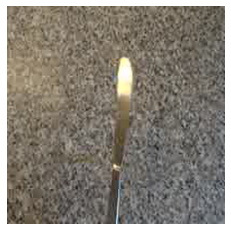

40.15% : matchstick
16.89% : missile
 6.47% : projectile
 2.70% : letter_opener
 2.64% : screwdriver


In [16]:
predict(image_path='data/knifey-spoony/train/knifey/knifey-03-0153.jpg')

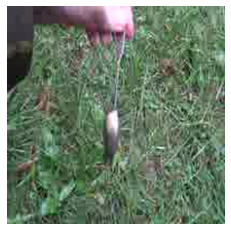

51.73% : black_stork
14.57% : white_stork
10.85% : crane
 5.59% : spoonbill
 3.12% : flamingo


In [17]:
predict(image_path='data/knifey-spoony/test/spoony/spoony-test-01-0157.jpg')

Comencemos preparando los datos. Keras utiliza un llamado *generador de datos* para introducir datos en la red neuronal, que iterará sobre los datos durante toda la eternidad.

Tenemos un pequeño conjunto de entrenamiento, así que el generador ayudará a inflar artificialmente su tamaño haciendo varias transformaciones en las imágenes. Utilizaremos un generador de datos incorporado que puede realizar estas transformaciones aleatorias. Esto también se llama **aumentado de datos** (data augmentation).

Busca en la [ayuda de Keras](https://keras.io/preprocessing/image/) qué parámetros se pueden configurar en el generador de datos.

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=180,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=[0.9, 1.5],
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

También necesitamos un generador de datos para el conjunto de test, pero esto no debería hacer ninguna transformación en las imágenes porque queremos saber la precisión exacta de la clasificación en esas imágenes específicas. Así que simplemente reescalamos los valores de los píxeles para que estén entre 0,0 y 1,0 porque esto es lo que se espera en el modelo VGG16.

In [0]:
datagen_test = ImageDataGenerator(rescale=1./255)

Los generadores de datos devolverán batches (lotes) de imágenes. Debido a que el modelo VGG16 es muy grande, el tamaño del batch no puede ser demasiado grande, ya que de lo contrario nos quedaremos sin RAM en la GPU.

In [0]:
batch_size = 20

Ahora creamos el generador de datos real que leerá los archivos del disco, redimensionará las imágenes y devolverá un lote aleatorio.

Es un poco incómodo que la construcción del generador de datos se divida en estos dos pasos, pero probablemente se deba a que hay diferentes tipos de generadores de datos disponibles para diferentes tipos de datos (imágenes, texto, etc.) y fuentes (memoria o disco).

In [21]:
generator_train = datagen_train.flow_from_directory(directory=train_dir,     # Este es el directorio objetivo
                                                    target_size=(150, 150),  # Todas las imágenes serán redimensionadas a 150x150
                                                    batch_size=batch_size,
                                                    shuffle=True)            # Hacer un recorrido aleatorio

Found 4170 images belonging to 3 classes.


Vamos a usar los datos de test de este dataset para hacer validación cruzada. En este caso, el generador de datos para el conjunto de validación no debería transformar y mezclar las imágenes.

In [22]:
generator_val = datagen_test.flow_from_directory(directory=test_dir,
                                                 target_size=(150, 150),
                                                 batch_size=batch_size,
                                                 shuffle=False)

Found 530 images belonging to 3 classes.


## 2. Extracción de Características

Ahora nos centraremos en Transfer Learning. Comenzaremos con la **Extracción de Características**, que consiste en usar representaciones aprendidas por otras redes para extraer características interesantes de nuevas muestras. Tras esta extracción, se usa la nueva representación dada por estas características para alimentar un nuevo clasificador, que (esta vez sí) será entrenado desde cero.

Como hemos visto en los ejemplos anteriores, las CNN usadas para clasificación de imágenes constan de dos partes bien diferenciadas: comienza por una serie de capas alternadas de convolución y pooling (lo que se llama la **base convolucional**), y acaban con un clasificador de capas densas. Nosotros aprovecharemos la base convolucional de la red preentrenada para obtener las nuevas representaciones y entrenaremos un nuevo codificador en la última parte.

Es importante entender porqué reusamos únicamente la base convolucional y no usamos también la parte del clasificador denso. La razón de ignorar esta última parte es simplemente que las representaciones aprendidas en la base convolucional son más genéricas y reutilizables, contienen información acerca de conceptos genéricos, que parecen útiles para todo tipo de problemas de visión artificial. Por otra parte, las representaciones aprendidas por el clasificador son mucho más específicas y relacionadas con el problema concreto para el que se ha entrenado y las clases de ese problema. Además estas capas densas pierden información acerca de dónde se sitúan las características aprendidas, algo que puede ser útil en algunos casos.

El nivel de generalidad (y por tanto de reusabilidad) de las representaciones extraídas por las capas convolucionales dependen de la profundidad de las capas del modelo. Las primeras capas extraen mapas de características muy genéricas y locales (bordes, colores, texturas, etc.), mientras que las capas más profundas extraen conceptos abstractos más elevados (como "orejas", "ojos", etc.). En consecuencia, si el dataset sobre el que se trabaja difiere mucho del dataset original con el que fue entrenada la red, es mejor usar solo las primeras capas, y no la base convolucional completa.

En nuestro caso, intentando clasificar cubiertos (cuchillos, cucharas y tenedores), podríamos llegar a usar incluso las redes densas de la red preentrenada, porque esas clases están contenidas en el problema original, pero nos quedaremos solo con la base convolucional para que el ejemplo sea lo más generalizable posible.

Además del modelo VGG16, Keras trae otros modelos preentrenados aptos para clasificación de imágenes, como [Xception](https://arxiv.org/pdf/1610.02357.pdf), [InceptionV3](https://arxiv.org/abs/1512.00567), [ResNet50](https://arxiv.org/abs/1512.03385), [VGG16](https://arxiv.org/abs/1409.1556), [VGG19](https://arxiv.org/abs/1409.1556), [MobileNet](https://arxiv.org/pdf/1704.04861.pdf), [DenseNet](https://arxiv.org/abs/1707.07012), ...

Recuerda que la primera vez que ejecutes el siguiente código se descargará el modelo preentrenado:

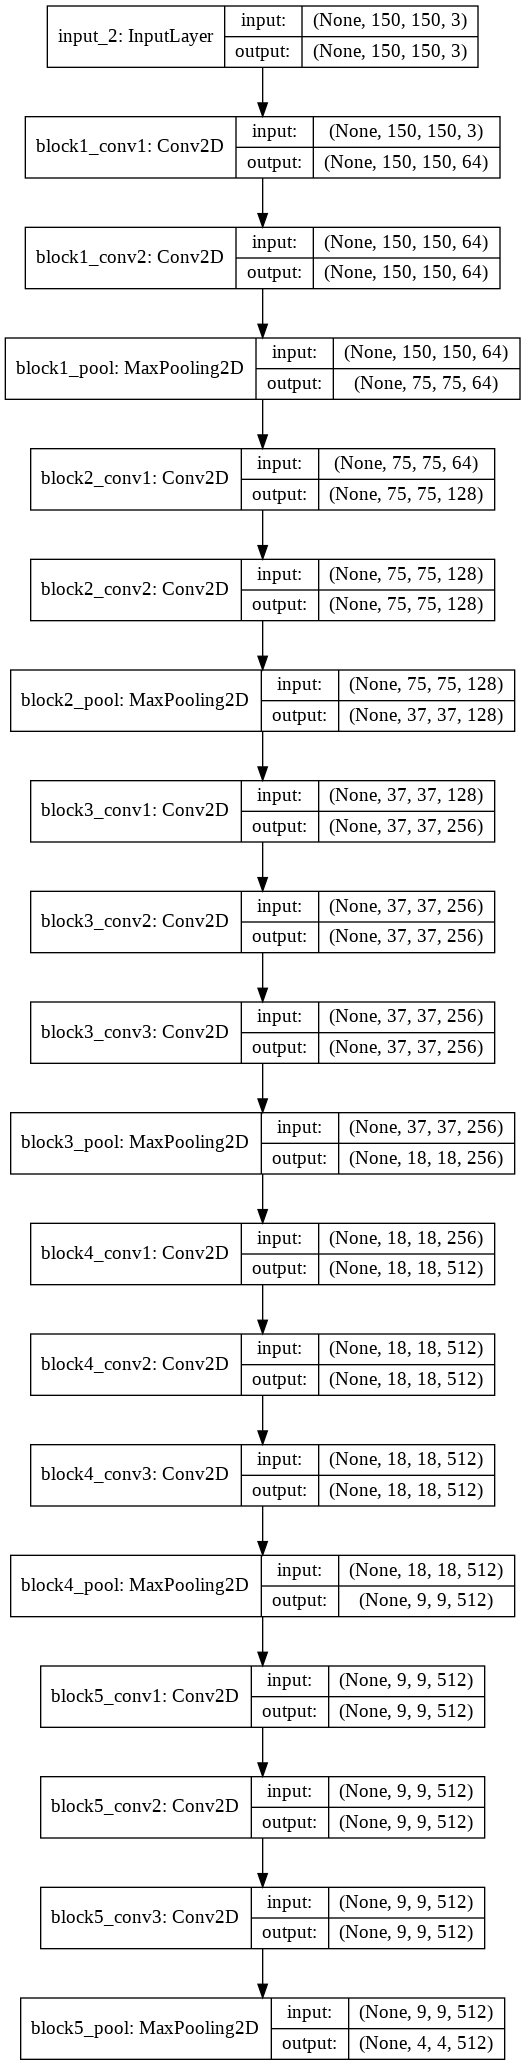

In [23]:
from keras.applications import VGG16
from keras.utils.vis_utils import plot_model

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

plot_model(conv_base, to_file='conv_base_plot.png', show_shapes=True, show_layer_names=True)

Ahora le hemos pasado 3 argumentos al constructor:

* `weights`, especifica el juego de pesos para inicializar el modelo (en nuestro caso, los asociados al problema ImageNet).
* `include_top`, indica si se debe incluir, o no, las capas densas de la red (las que se ajustan a la clasificación de las 1,000 clases de ImageNet).
* `input_shape`, la forma de los tensores de entrada. Es opcional, y si no se indicara se podrían pasar entradas de cualquier tamaño, pero en nuestro caso lo tenemos perfectamente prefijado para que el procedimiento sea similar al que hicimos en el ejemplo anterior.

Podemos comprobar que la base convolucional de VGG16 es muy parecida a la arquitectura generada para problemas anteriores:

In [24]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

El mapa de características final tiene la forma `(4, 4, 512)`. Aquí conectaremos nuestro clasificador de capas densas.

En este punto, hay dos posibles vías para proceder: 

* Ejecutar la base convolucional sobre el dataset, grabar su salida en un array, y entonces usar estos datos como entrada de un clasificador denso independiente parecido al que vimos anteriormente. Esta solución es rápida y fácil de ejecutar, porque solo requiere ejecutar la base convolucional una vez sobre cada imagen de entrada, que es la parte que más recursos consume del proceso. Por contrario, esta opción no permite hacer uso de *data augmentation*.
* Extender el modelo (`conv_base`) añadiendo capas densas encima, y ejecutar la red completa sobre los datos de entrada. Esta opción permite hacer uso de *data augmentation*, aunque consume muchos más recursos que la primera opción.

En esta introducción, vamos a usar la última técnica. 


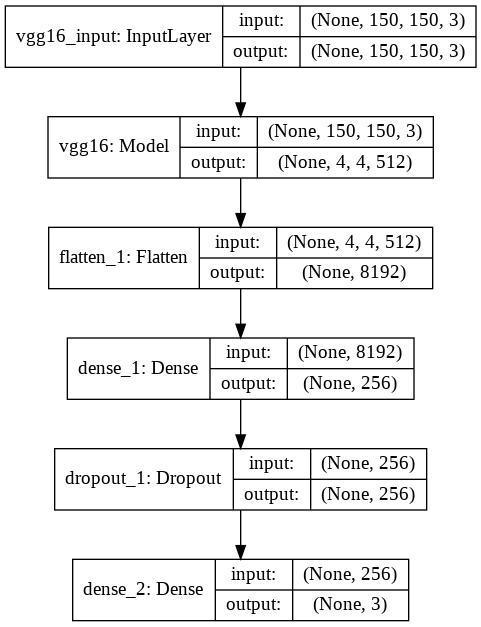

In [25]:
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout
from keras import optimizers

# Creamos un nuevo modelo Secuencial de Keras
model = Sequential()

# Añadimos la parte convolucional del modelo VGG16 de arriba
model.add(conv_base)

# Aplanamos la salida del modelo VGG16 dado que ésta viene
# de una capa convolucional.
model.add(Flatten())

# Añade una capa densa (es decir, totalmente conectada o fully-connected).
# Esto es para combinar las características que el modelo VGG16 ha
# reconocido en la imagen.
model.add(Dense(256, activation='relu'))

# Añade una capa dropout el cual prevendrá el sobreajuste y mejorará
# la capacidad de generalización en datos desconocidos (es decir, el 
# conjunto de test)
model.add(Dropout(0.5))

# Añade la capa final para la clasificación real, usando softmax.
model.add(Dense(3, activation='softmax'))

model.compile(optimizer=optimizers.Adam(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 16,812,867
Trainable params: 16,812,867
Non-trainable params: 0
_________________________________________________________________


Como puedes observar, la base convolucional de VGG16 tiene 14.714.688 parámetros, y sobre ella hemos añadido un clasificador con otros 2 millones de parámetros.

Antes de compilar y entrenar tu modelo, recuerda que es importante **congelar** la base convolucional, lo que significa que durante el proceso de entrenamiento los pesos de sus capas **no** serán modificados. Si no se hace así, las representaciones aprendidas en el entrenamiento original se modificarían. Como las capas densas que se añaden se inicializan aleatoriamente, habría grandes modificaciones sobre los pesos que se propagarían a través de la red, lo que destruiría el aprendizaje previo.

Keras proporciona la propiedad `trainable` a las capas para indicar si deben estar congeladas o no:

In [27]:
print('Nº de pesos entrenables antes de congelar la base convolucional:', len(model.trainable_weights))

conv_base.trainable = False

print('Nº de pesos entrenables tras congelar la base convolucional:', len(model.trainable_weights))

Nº de pesos entrenables antes de congelar la base convolucional: 30
Nº de pesos entrenables tras congelar la base convolucional: 4


Indica 4 pesos por entrenar porque son 2 capas, y en cada capa se considera la matriz de pesos y la de bias. Es importante tener en cuenta que tras congelar las capas debes compilar el modelo, si no, no tendrá efecto.

Una **época** (epoch) normalmente significa un procesamiento completo del conjunto de entrenamiento. Pero el generador de datos que creamos arriba, producirá batches de datos de entrenamiento para la eternidad. Por lo tanto, necesitamos definir el número de pasos que queremos ejecutar para cada "época" y este número se multiplica por el tamaño de batch definido anteriormente. En este caso tenemos 100 pasos por época y un tamaño de batch de 20, por lo que la "época" consiste en 2.000 imágenes aleatorias del conjunto de entrenamiento. Nosotros ejecutaremos 20 de esas "épocas".

La razón por la que se eligieron estos números en particular, fue porque parecían ser suficientes para entrenar con este modelo y el conjunto de datos en particular, lo que no llevó mucho tiempo, y resultó en 20 puntos de datos (uno para cada "época") que se pueden mostrar después.

In [28]:
epochs = 10
steps_per_epoch = 100
steps_val = generator_val.n / batch_size
steps_val

26.5

Ya podemos entrenar el modelo haciendo uso de la técnica de data augmentation. Para ello podemos utilizar una función `fit` especial para recorrer los datos con generadores:

In [29]:
history = model.fit_generator(generator=generator_train,
                              epochs=epochs,
                              steps_per_epoch=steps_per_epoch,
                              validation_data=generator_val,
                              validation_steps=steps_val)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/10


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


100/100 [==============================] - 18s 176ms/step - loss: 1.0185 - categorical_accuracy: 0.5090 - val_loss: 0.4074 - val_categorical_accuracy: 0.7321
Epoch 2/10
100/100 [==============================] - 16s 159ms/step - loss: 0.6525 - categorical_accuracy: 0.7045 - val_loss: 0.1160 - val_categorical_accuracy: 0.8509
Epoch 3/10
100/100 [==============================] - 16s 159ms/step - loss: 0.4122 - categorical_accuracy: 0.8350 - val_loss: 0.5065 - val_categorical_accuracy: 0.7868
Epoch 4/10
100/100 [==============================] - 16s 158ms/step - loss: 0.3862 - categorical_accuracy: 0.8452 - val_loss: 0.4997 - val_categorical_accuracy: 0.7528
Epoch 5/10
100/100 [==============================] - 16s 160ms/step - loss: 0.2945 - categorical_accuracy: 0.8889 - val_loss: 0.1067 - val_categorical_accuracy: 0.8377
Epoch 6/10
100/100 [==============================] - 16s 158ms/step - loss: 0.2401 - categorical_accuracy: 0.9050 - val_loss: 0.0544 - val_categorical_accuracy: 0.78

Si vemos los resultados obtenidos:

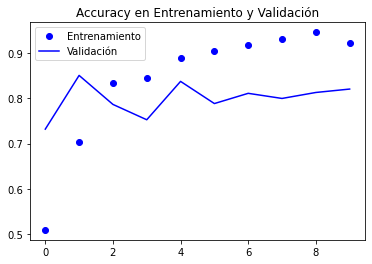

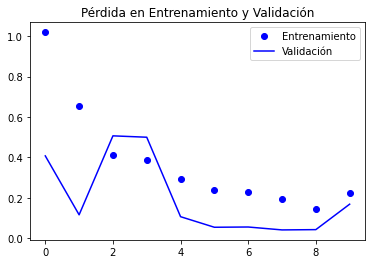

In [30]:
ent_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
ent_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(ent_acc))

plt.plot(epochs, ent_acc, 'bo', label='Entrenamiento')
plt.plot(epochs, val_acc, 'b', label='Validación')
plt.title('Accuracy en Entrenamiento y Validación')
plt.legend()

plt.figure()

plt.plot(epochs, ent_loss, 'bo', label='Entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Validación')
plt.title('Pérdida en Entrenamiento y Validación')
plt.legend()

plt.show()

Veamos algunos ejemplos de predicción errónea y la matriz de confusión. Vamos a usar unas funciones auxiliares, sacadas de los interesantes [tutoriales de TensorFlow de Hvass Labs](https://github.com/Hvass-Labs/TensorFlow-Tutorials), que nos van a ayudar a hacerlo. No hace falta que las entendamos ahora, solo que muestran varias imágenes, la clase correcta, la clase predicha, y finalmente la matriz.

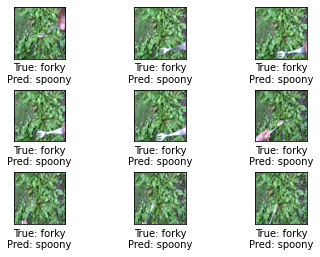

Confusion matrix:
[[ 94   2  55]
 [ 11 118   8]
 [ 11   8 223]]
(0) forky
(1) knifey
(2) spoony


In [33]:
#@title
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = model.predict_generator(generator_test,
                                     steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

cls_test = generator_val.classes
image_paths_test = path_join(test_dir, generator_val.filenames)
class_names = list(generator_train.class_indices.keys())
steps_test = steps_val
generator_test = generator_val # vamos a usar val como test

example_errors()

Podemos grabar los pesos del modelo como sigue, si lo queréis guardar para otro momento (después hay que crear un modelo con exactamente la misma arquitectura y usar el método `load_weights`):


In [0]:
model.save('knifey.h5')

## 4. Conclusiones

* Las redes convolucionales aportan los mejores modelos de ML para tareas de visión artificial. Incluso es posible entrenar una red desde cero sobre pocas muestras obteniendo resultados decentes.
* El sobreajuste es el principal problema cuando se trabaja con datasets pequeños. Entre las técnicas de regularización vistas, **data augmentation** puede ser una ayuda esencial cuando se trabaja con imágenes.
* Podemos descargar modelos pre-entrenados directamente desde Keras, y emplearlos para intentar clasificar imágenes. Aunque podemos encontrarnos resultados extraños si el dominio de nuestra tarea es distinta a la del dataset ImageNet.
* Es fácil reutilizar una red convolucional previamente entrenada por medio de la **extracción de características**. Es rápido y funciona bien con datasets pequeños.

## 5. Siguientes pasos

* Las clases están desbalanceadas. Hay 1210 de Knifey, 1966 de Spoony, y 994 de Forky. Puedes usar la función `compute_class_weight` de Sklearn para intentar compensar el desbalanceo dando más peso a la clase con menos datos. Puedes ver cómo se hace en este [Tutorial de Transfer Learning](https://github.com/miguelamda/TL-tutorial)
* Puedes ver cómo se hace **fine tuning** para adaptar aún más el modelo en los notebooks del curso de [Deep Learning](https://github.com/miguelamda/DL/blob/master/5.%20Redes%20Convolucionales/Practica5.3.%20CNN%20Preentrenadas.ipynb), o en el libro [Deep Learning with Python](https://github.com/fchollet/deep-learning-with-python-notebooks)
* Puedes probar a bajar el nivel de abstracción de las características que estás extrayendo para tu clasificador. Quizás conviene utilizar una capa anterior. Puedes ver más en este [Tutorial de Transfer Learning](https://github.com/miguelamda/TL-tutorial)

## 6. Recursos

* [Deep Learning with Python de François Chollet](https://github.com/fchollet/deep-learning-with-python-notebooks)
* [TensorFlow tutorial de Magnus Erik Hvass Pedersen](https://github.com/Hvass-Labs/TensorFlow-Tutorials)